In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [2]:
quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.actor.loc[categ.actor=="GNAA"] = np.nan
categ.vocal_channel.loc[categ.vocal_channel=="GNAA"] = np.nan

categ.isna().sum()

known_actors_filter = np.logical_not(categ.actor.isna())
known_quant = quant.loc[known_actors_filter]
known_categ = categ.loc[known_actors_filter]

## Tree

### GridSearch

In [3]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, cohen_kappa_score, balanced_accuracy_score, f1_score
kappa_scorer = make_scorer(cohen_kappa_score)

def tree_feature_gridsearch(feature):
    good_samples_filter = np.logical_not(categ[feature].isna())
    X = quant.loc[good_samples_filter].values
    y = categ[feature].loc[good_samples_filter].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    scaler = StandardScaler()
    pca = PCA()
    dec_tree = tree.DecisionTreeClassifier()

    n_components = list(range(1, 19))
    criterion = ['gini', 'entropy']
    max_depth = list(range(2,13))
    min_samples_split = [2,4, 6, 8]

    parameters = dict(  pca__n_components=n_components,
                        dec_tree__criterion=criterion,
                        dec_tree__max_depth=max_depth,
                        dec_tree__min_samples_split=min_samples_split)

    pipe = Pipeline(steps=[    ('std_slc', scaler),
                            ('pca', pca),
                            ('dec_tree', dec_tree)])
    clf_GS = GridSearchCV(pipe, parameters, scoring=kappa_scorer)
    clf_GS.fit(X_train, y_train)
    optimal_results = clf_GS.best_estimator_.get_params()
    optimal_results["kappa"] = clf_GS.score(X_test, y_test)

    return optimal_results

# dtree_gs_df = pd.DataFrame()
# for feature in categ.columns:
#     print(feature)
#     results = tree_feature_gridsearch(feature)
#     row={k:results[k] for k in ["pca__n_components", "dec_tree__criterion","dec_tree__max_depth","dec_tree__min_samples_split", "kappa"]}
#     row["feature"] = feature
#     row = pd.DataFrame(row, index = [0])
#     dtree_gs_df = pd.concat([dtree_gs_df, row], ignore_index=True)

# dtree_gs_df.to_csv("tree_optimal_results.csv")

dtree_gs_df = pd.read_csv("tree_optimal_results.csv")

In [4]:
display(dtree_gs_df.sort_values("kappa"))

,Unnamed: 0,pca__n_components,dec_tree__criterion,dec_tree__max_depth,dec_tree__min_samples_split,kappa,feature
4,4,1,entropy,11,8,-0.010695,repetition
3,3,15,entropy,5,8,0.207730,statement
1,1,11,gini,11,4,0.237075,emotion
5,5,14,gini,11,2,0.284808,actor
2,2,3,gini,5,8,0.382748,emotional_intensity
0,0,18,entropy,9,2,0.804452,vocal_channel
6,6,11,entropy,10,2,0.822498,sex


## Bayes

### Grid search

In [5]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, cohen_kappa_score, f1_score
kappa_scorer = make_scorer(cohen_kappa_score)

def nbc_feature_gridsearch(feature):
    good_samples_filter = np.logical_not(categ[feature].isna())
    X = quant.loc[good_samples_filter].values
    y = categ[feature].loc[good_samples_filter].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    scaler = StandardScaler()
    pca = PCA()
    nbcclf = GaussianNB()

    n_components = list(range(1, len(quant.columns)+1))

    parameters = dict(pca__n_components=n_components)

    pipe = Pipeline(steps=[ ('std_slc', scaler),
                            ('pca', pca),
                            ('nbcclf', nbcclf)])
    clf_GS = GridSearchCV(pipe, parameters, scoring=kappa_scorer)
    clf_GS.fit(X_train, y_train)
    optimal_results = clf_GS.best_estimator_.get_params()
    optimal_results["kappa"] = clf_GS.score(X_test, y_test)
    return optimal_results

# nbc_gs_df = pd.DataFrame()
# for feature in categ.columns:
#     print(feature)
#     results = nbc_feature_gridsearch(feature)
#     row={k:results[k] for k in ["pca__n_components", "kappa"]}
#     row["feature"] = feature
#     row = pd.DataFrame(row, index = [0])
#     nbc_gs_df = pd.concat([nbc_gs_df, row], ignore_index=True)

# nbc_gs_df.to_csv("nbc_optimal_results.csv")

nbc_gs_df = pd.read_csv("nbc_optimal_results.csv")

In [6]:
display(nbc_gs_df.sort_values("kappa"))

,Unnamed: 0,pca__n_components,kappa,feature
4,4,1,0.007256,repetition
1,1,16,0.251936,emotion
3,3,18,0.352264,statement
2,2,4,0.431032,emotional_intensity
5,5,18,0.495179,actor
6,6,17,0.855796,sex
0,0,16,0.862695,vocal_channel


## KNN

### Grid search

In [7]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, cohen_kappa_score, f1_score
kappa_scorer = make_scorer(cohen_kappa_score)

def knn_feature_gridsearch(feature):
    good_samples_filter = np.logical_not(categ[feature].isna())
    X = quant.loc[good_samples_filter].values
    y = categ[feature].loc[good_samples_filter].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    scaler = StandardScaler()
    pca = PCA()
    knnclf = KNeighborsClassifier()

    n_components = list(range(1, len(quant.columns)+1))
    weights = ['distance', 'uniform']
    k = list(range(1,15))
    p = [1,2,3,4, np.inf]

    parameters = dict(  pca__n_components=n_components,
                        knnclf__weights=weights,
                        knnclf__n_neighbors=k,
                        knnclf__p=p)

    pipe = Pipeline(steps=[ ('std_slc', scaler),
                            ('pca', pca),
                            ('knnclf', knnclf)])
    clf_GS = GridSearchCV(pipe, parameters, scoring=kappa_scorer)
    clf_GS.fit(X_train, y_train)
    optimal_results = clf_GS.best_estimator_.get_params()
    optimal_results["kappa"] = clf_GS.score(X_test, y_test)

    return optimal_results

# knn_gs_df = pd.DataFrame()
# for feature in categ.columns:
#     print(feature)
#     results = knn_feature_gridsearch(feature)
#     row={k:results[k] for k in ["pca__n_components", "knnclf__n_neighbors", "knnclf__weights","knnclf__p","kappa"]}
#     row["feature"] = feature
#     row = pd.DataFrame(row, index = [0])
#     knn_gs_df = pd.concat([knn_gs_df, row], ignore_index=True)

# knn_gs_df.to_csv("knn_optimal_results.csv")
def reload_knn_table():
    global knn_gs_df
    knn_gs_df = pd.read_csv("knn_optimal_results.csv")
reload_knn_table()


In [8]:
display(knn_gs_df.sort_values("kappa"))

,Unnamed: 0,pca__n_components,knnclf__n_neighbors,knnclf__weights,knnclf__p,kappa,feature
4,4,2,4,uniform,2,-0.045828,repetition
3,3,13,14,distance,2,0.191081,statement
1,1,18,1,distance,1,0.353900,emotion
2,2,11,7,distance,2,0.378603,emotional_intensity
5,5,18,9,distance,1,0.614393,actor
0,0,18,5,distance,1,0.890370,vocal_channel
6,6,18,6,distance,1,0.934162,sex


## Plots

In [9]:
from matplotlib import rcParams
rcParams["figure.autolayout"] = False

## Best Values

In [10]:
optimal_df = pd.DataFrame(columns=["classifier", "feature", "kappa"])
for clfdf, clfname in zip([dtree_gs_df, knn_gs_df, nbc_gs_df], ["dt", "knn", "nbc"]):
    add = dict(feature = clfdf.feature, kappa=clfdf.kappa, classifier=[clfname]*len(clfdf))
    add = pd.DataFrame(add, index = range(len(clfdf)))
    optimal_df=pd.concat([optimal_df, add], ignore_index=True)
display(optimal_df.sort_values("kappa"))

,classifier,feature,kappa
11,knn,repetition,-0.045828
4,dt,repetition,-0.010695
18,nbc,repetition,0.007256
10,knn,statement,0.191081
3,dt,statement,0.207730
1,dt,emotion,0.237075
15,nbc,emotion,0.251936
5,dt,actor,0.284808
17,nbc,statement,0.352264
8,knn,emotion,0.353900


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


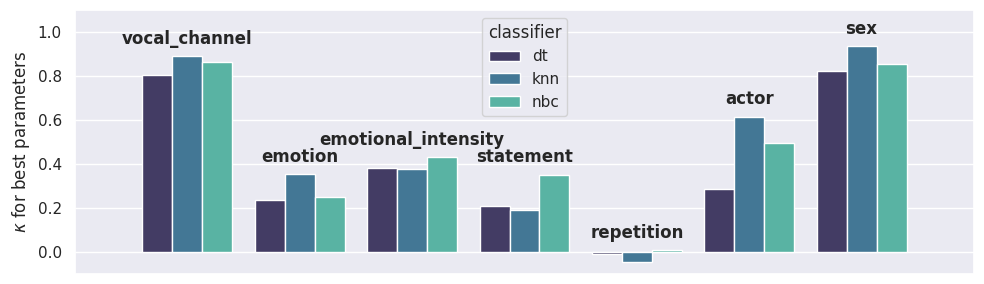

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(data=optimal_df, x="feature",y="kappa",  hue="classifier", palette="mako")
plt.xlabel("")
plt.ylabel("$\kappa$ for best parameters")
plt.xticks([])
fig.tight_layout()

for i,label in enumerate(categ.columns):
    y = optimal_df.loc[optimal_df.feature == label].kappa.max()
    ax.text(i, y + 0.08, label, ha="center", va="center", fontweight="bold",  rotation=0)
    # for j, (classifier, par, col) in enumerate(zip(["KNN", "decision tree"], ["k", "depth"], ["r", "g"])):
    #     if label != "repetition":
    #         best_par = optimal_df.loc[(optimal_df.feature==label)&(optimal_df.classifier==classifier)].best_par.values[0]
    #         ax.text(i-j/4  , 0.02, f"{int(best_par)}", ha="center", rotation=0, color=col, fontweight="bold")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-1,7)

ax.set_yticks([0, 0.2,0.4,0.6,0.8,1.0])
# ax.text(3.3,-0.15, "best depth",ha="center" ,color="g", fontweight="bold")
# ax.text(3.3,-0.25, "best k", ha="center",color="r", fontweight="bold")
fig.savefig("images/comparison_optimal.pdf")

## Confusion matrix

In [12]:
TEST_SIZE=0.25

### Actor

In [13]:
known_categ.actor = known_categ.actor.apply(float).apply(int)

actor_sex = {}
for act, sex in zip(known_categ.actor,  known_categ.sex.values):
    actor_sex[act] = sex

## Encoding dictionary to order stuff
actor_encoder = {}
c = 0
for male in np.sort(np.unique(known_categ[known_categ.sex=="M"].actor)):
    actor_encoder[male] = c 
    c+=1
for female in np.sort(np.unique(known_categ[known_categ.sex=="F"].actor)):
    actor_encoder[female] = c 
    c+=1

actor_decoder = {value:key for key, value in actor_encoder.items()}
print(actor_encoder)
print(actor_sex)

{1: 0, 3: 1, 5: 2, 7: 3, 9: 4, 11: 5, 13: 6, 15: 7, 17: 8, 19: 9, 21: 10, 23: 11, 2: 12, 4: 13, 6: 14, 8: 15, 10: 16, 12: 17, 14: 18, 16: 19, 18: 20, 20: 21, 22: 22, 24: 23}
{2: 'F', 16: 'F', 14: 'F', 12: 'F', 6: 'F', 22: 'F', 20: 'F', 8: 'F', 23: 'M', 7: 'M', 13: 'M', 3: 'M', 17: 'M', 21: 'M', 1: 'M', 15: 'M', 5: 'M', 19: 'M', 9: 'M', 11: 'M', 24: 'F', 18: 'F', 4: 'F', 10: 'F'}


/tmp/ipykernel_14444/3607902526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_categ.actor = known_categ.actor.apply(float).apply(int)


In [14]:
## Select best estimator from optimals
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

scaler = StandardScaler()
reducer = PCA(n_components=18)
subclf = KNeighborsClassifier(n_neighbors=8, weights="distance", p=1.0)
clf = make_pipeline(scaler, reducer, subclf)

X = known_quant.values
y = known_categ.actor.map(actor_encoder).values

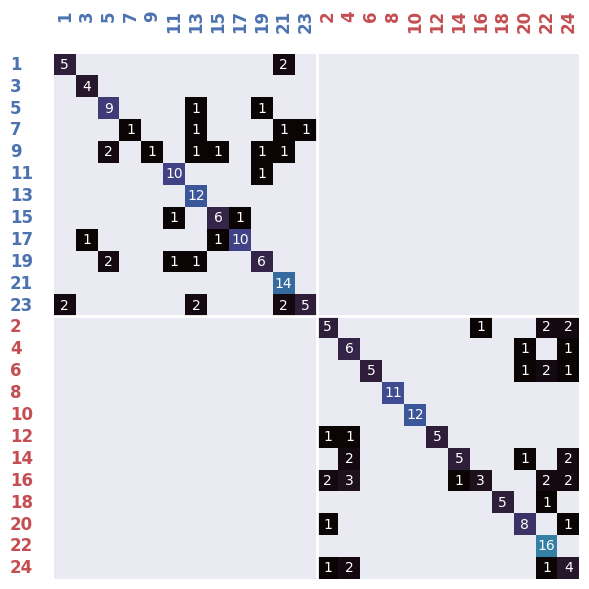

In [15]:
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, f1_score

fig,ax = plt.subplots(figsize=(6,6))

cfm = np.zeros((24,24))

actor_accuracy_df = pd.DataFrame(columns =["actor_id", "actor", "precision", "recall", "f1", "FDR", "PPV"])
predictions_df = pd.DataFrame(columns=["actor", "true", "predicted"])

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i**2, test_size=TEST_SIZE)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    cfm += confusion_matrix(y_test, predicted)/10
    for actor, act_id in actor_encoder.items():
        row = dict(actor_id=act_id, actor=actor)
        row["precision"] = accuracy_score((y_test==act_id).astype(int), (predicted==act_id).astype(int))
        row["recall"] = recall_score((y_test==act_id).astype(int), (predicted==act_id).astype(int))
        row["f1"] = f1_score((y_test==act_id).astype(int), (predicted==act_id).astype(int))
        # row["FDR"] = false_discovery_rate( y_test==act_id, predicted==act_id)
        # row["PPV"] = positive_predictive_value( y_test==act_id, predicted==act_id)
        row = pd.DataFrame(row, index=[0])
        actor_accuracy_df = pd.concat([actor_accuracy_df, row], ignore_index=True)


cfm = cfm.astype(int)
cmap = sns.color_palette("mako", as_cmap=True)
sns.heatmap(cfm,cmap=cmap,ax=ax, annot=True,annot_kws=dict(size=10), fmt="d", vmax=30,cbar=False, cbar_kws =dict(shrink=0.75),mask=(cfm==0))
for i in range(len(actor_encoder.keys())):
    if actor_sex[actor_decoder[i]] == "M":
        color="b"
    else:
        color="r"
    ax.text(i + 0.5 , -2, actor_decoder[i], va="top", ha="center", rotation=90, fontweight="bold", color=color);
    ax.text(-2, i+0.5, actor_decoder[i], ha="left", va="center",rotation=0, fontweight="bold", color=color);
ax.set_aspect("equal")
ax.set_xticks(range(1,25),labels=[]);
ax.set_yticks(range(1,25), labels=[]);
ax.axvline(12, color="w",lw=2)
ax.axhline(12, color="w", lw=2)
fig.tight_layout()
fig.savefig("images/actor_cfm.pdf")

### emotion

In [16]:
emotiontion_encoder = {emotion:i for i, emotion in enumerate(np.unique(known_categ.emotion))}
emotiontion_decoder = {i:emotion for i, emotion in enumerate(np.unique(known_categ.emotion))}

In [17]:
clf = make_pipeline(StandardScaler(), PCA(n_components=18),KNeighborsClassifier(n_neighbors=4, weights="distance", p=2.0))
X = quant.values
y = categ.emotion.map(emotiontion_encoder).values

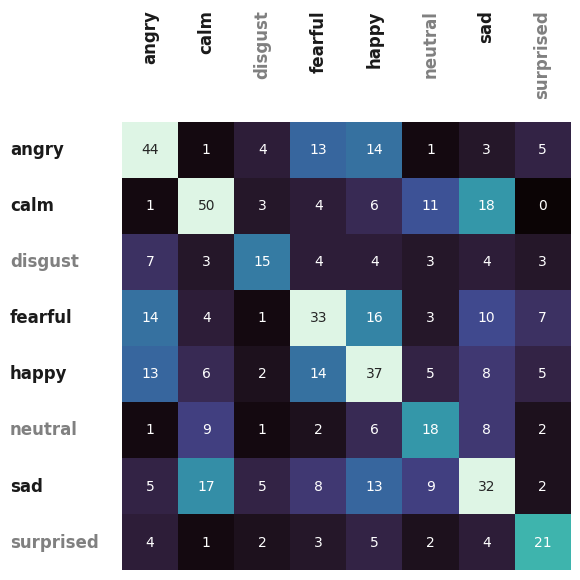

In [18]:
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, f1_score

fig,ax = plt.subplots(figsize=(6,6))
cfm = np.zeros((8,8))
predictions_df = pd.DataFrame(columns=["emotion", "true", "predicted"])

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i**2, test_size=TEST_SIZE)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    cfm += confusion_matrix(y_test, predicted)/10
    for emotion, emotion_id in emotiontion_encoder.items():
        row = dict(emotion_id=emotion_id, emotion=emotion)
        

        row = pd.DataFrame(row, index=[0])


cfm = cfm.astype(int)
cmap = sns.color_palette("mako", as_cmap=True)
sns.heatmap(cfm,cmap=cmap,ax=ax, annot=True,annot_kws=dict(size=10), fmt="d", vmax=30,cbar=False, cbar_kws =dict(shrink=0.75))#,mask=(cfm==0))
ax.set_aspect("equal")

for i in range(len(emotiontion_encoder.keys())):
    if emotiontion_decoder[i] in ["surprised", "disgust","neutral"]:
        color="gray"
    else:
        color="k"
    ax.text(i + 0.5 , -2, emotiontion_decoder[i], va="top", ha="center", rotation=90, fontweight="bold", color=color);
    ax.text(-2, i+0.5, emotiontion_decoder[i], ha="left", va="center",rotation=0, fontweight="bold", color=color);
ax.set_aspect("equal")
ax.set_xticks(range(1,8),labels=[]);
ax.set_yticks(range(1,8), labels=[]);

fig.tight_layout()
fig.savefig("images/emotiontion_cfm.pdf")

## Bayes factor comparison

### actor

In [19]:
classifiers = [
                make_pipeline(StandardScaler(), PCA(n_components=18),KNeighborsClassifier(n_neighbors=8, weights="distance", p=1.0)),
                make_pipeline(StandardScaler(), PCA(n_components=18), GaussianNB()),
                make_pipeline(StandardScaler(), PCA(n_components=14), tree.DecisionTreeClassifier(max_depth=11, criterion="gini", min_samples_split=6))
]   
classifiers_names = ["knn", "nbc", "dt"]

In [20]:
predictions_df = pd.DataFrame(columns = ["classifier", "actor", "is_actor", "is_classified_actor"])
X = known_quant.values
y = known_categ.actor.map(actor_encoder).values

In [21]:
for clf , clfname in  zip(classifiers, classifiers_names):
    print(clfname)
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i**2, test_size=0.2)
        clf.fit(X_train, y_train)
        predicted = clf.predict(X_test)
        for actor, act_id in actor_encoder.items():
            row = dict(classifier=clfname, actor=actor, is_actor=(y_test==act_id), is_classified_actor=(predicted==act_id))
            row = pd.DataFrame(row, index=range(len(y_test)))
            predictions_df = pd.concat([predictions_df, row], ignore_index=True)
    

knn
nbc
dt


In [22]:
from sklearn.metrics import class_likelihood_ratios
bayes_df = pd.DataFrame(columns=["classifier", "actor", "positive_likelihood_ratio", "negative_likelihood_ratio"])

for clfname in classifiers_names:
    for i in range(1,25):
        subpred = predictions_df[(predictions_df.actor==i)&(predictions_df.classifier==clfname)]
        poslik, neglik = class_likelihood_ratios(subpred.is_actor.astype(int), subpred.is_classified_actor.astype(int))
        row = dict(actor=str(i), classifier=clfname, positive_likelihood_ratio=poslik, negative_likelihood_ratio=neglik) 
        bayes_df = pd.concat([bayes_df, pd.DataFrame(row, index=[0])], ignore_index=True)
display(bayes_df)

,classifier,actor,positive_likelihood_ratio,negative_likelihood_ratio
0,knn,1,52.423913,0.428623
1,knn,2,12.251493,0.616951
2,knn,3,23.960925,0.580039
3,knn,4,13.908568,0.411560
4,knn,5,26.872189,0.315829
...,...,...,...,...
67,dt,20,12.778872,0.698469
68,dt,21,43.198751,0.473577
69,dt,22,17.030441,0.518823
70,dt,23,9.312738,0.766553


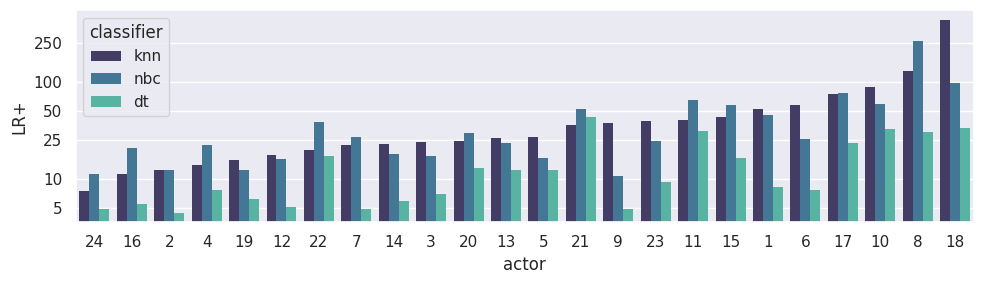

In [23]:
fig, ax = plt.subplots(figsize=(10,3))
# order=bayes_df[bayes_df.classifier=="knn"].groupby("actor").mean().sort_values("negative_likelihood_ratio", ascending=False).index
# obj=sns.barplot(data=bayes_df, x="actor", y="negative_likelihood_ratio",order=order, hue="classifier", palette="mako",ax=ax[0])
# obj.legend_.remotionve()
order=bayes_df[bayes_df.classifier=="knn"].groupby("actor").mean().sort_values("positive_likelihood_ratio", ascending=True).index
sns.barplot(data=bayes_df, x="actor", y="positive_likelihood_ratio",order=order, hue="classifier",linewidth=0 ,palette="mako",ax=ax)
ax.set_ylabel("LR+")

fig.tight_layout()
ax.set_yscale("log")
u = [5,10,25,50, 100, 250]
ax.set_yticks(u)
ax.set_yticklabels(u)
fig.savefig("bayes_comparison.pdf")

In [34]:
p = np.sum(known_categ.actor==22)/len(known_categ)
print("prevalence",p)
o = p/(1-p)
print("pre-odds",o)
print("bayes factor", bayes_df[(bayes_df.actor == "22")&(bayes_df.classifier=="knn")].positive_likelihood_ratio.values[0])
o = o*bayes_df[(bayes_df.actor == "22")&(bayes_df.classifier=="knn")].positive_likelihood_ratio.values[0]
print("post_odds", o)
p=o/(1+o)
print("post-p",p)

prevalence 0.04939209726443769
pre-odds 0.05195843325339728
bayes factor 38.73879142300195
post_odds 2.012806908469326
post-p 0.6680836076188978


### emotion

In [25]:
classifiers = [
                make_pipeline(StandardScaler(), PCA(n_components=18),KNeighborsClassifier(n_neighbors=4, weights="distance", p=2.0)),
                make_pipeline(StandardScaler(), PCA(n_components=16), GaussianNB()),
                make_pipeline(StandardScaler(), PCA(n_components=12), tree.DecisionTreeClassifier(max_depth=7, criterion="entropy", min_samples_split=2))
]   
classifiers_names = ["knn", "nbc", "dt"]

In [26]:
emotion_predictions_df = pd.DataFrame(columns = ["classifier", "emotion", "is_emotion", "is_classified_emotion"])
X = quant.values
y = categ.emotion.map(emotiontion_encoder).values

In [27]:
for clf , clfname in  zip(classifiers, classifiers_names):
    print(clfname)
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i**2, test_size=0.2)
        clf.fit(X_train, y_train)
        predicted = clf.predict(X_test)
        for emotion, emotion_id in emotiontion_encoder.items():
            row = dict(classifier=clfname, emotion=emotion, is_emotion=(y_test==emotion_id), is_classified_emotion=(predicted==emotion_id))
            row = pd.DataFrame(row, index=range(len(y_test)))
            emotion_predictions_df = pd.concat([emotion_predictions_df, row], ignore_index=True)

knn
nbc
dt


In [28]:
from sklearn.metrics import class_likelihood_ratios
emotion_bayes_df = pd.DataFrame(columns=["classifier", "emotion", "positive_likelihood_ratio", "negative_likelihood_ratio"])

for clfname in classifiers_names:
    for i in range(0,8):
        subpred = emotion_predictions_df[(emotion_predictions_df.emotion==emotiontion_decoder[i])&(emotion_predictions_df.classifier==clfname)]
        poslik, neglik = class_likelihood_ratios(subpred.is_emotion.astype(int), subpred.is_classified_emotion.astype(int))
        row = dict(emotion=emotiontion_decoder[i], classifier=clfname, positive_likelihood_ratio=poslik, negative_likelihood_ratio=neglik) 
        emotion_bayes_df = pd.concat([emotion_bayes_df, pd.DataFrame(row, index=[0])], ignore_index=True)

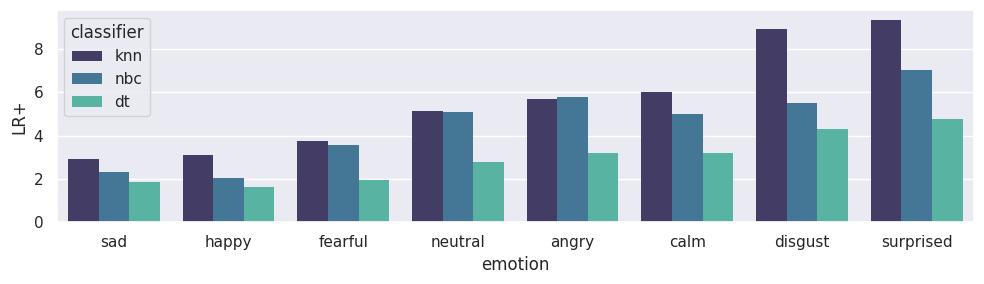

In [29]:
fig, ax = plt.subplots(figsize=(10,3))
# order=bayes_df[bayes_df.classifier=="knn"].groupby("actor").mean().sort_values("negative_likelihood_ratio", ascending=False).index
# obj=sns.barplot(data=bayes_df, x="actor", y="negative_likelihood_ratio",order=order, hue="classifier", palette="mako",ax=ax[0])
# obj.legend_.remotionve()
order=emotion_bayes_df[emotion_bayes_df.classifier=="knn"].groupby("emotion").mean().sort_values("positive_likelihood_ratio", ascending=True).index
sns.barplot(data=emotion_bayes_df, x="emotion", y="positive_likelihood_ratio",order=order, hue="classifier",linewidth=0, palette="mako",ax=ax)
ax.set_ylabel("LR+")

fig.tight_layout()
fig.savefig("bayes_comparison_2.pdf")

In [30]:
test_emotion = "calm"
p = np.sum(known_categ.emotion==test_emotion)/len(known_categ)
print("prevalence",p)
o = p/(1-p)
print("pre-odds",o)
print("bayes factor", emotion_bayes_df[(emotion_bayes_df.emotion == test_emotion)&(emotion_bayes_df.classifier=="knn")].positive_likelihood_ratio.values[0])
o = o*emotion_bayes_df[(emotion_bayes_df.emotion == test_emotion)&(emotion_bayes_df.classifier=="knn")].positive_likelihood_ratio.values[0]
print("post_odds", o)
p=o/(1+o)
print("post-p",p)

prevalence 0.15501519756838905
pre-odds 0.18345323741007194
bayes factor 6.02776008492569
post_odds 1.105812101910828
post-p 0.5251238232069265


## Tabls

In [31]:
from sklearn.metrics import accuracy_score, recall_score

reload_knn_table()

knn_gs_df["accuracy"] = np.zeros(7)
knn_gs_df["recall"] = np.zeros(7)

for index, opt_vals in knn_gs_df.iterrows():
    feat = opt_vals["feature"]
    scaler = StandardScaler()
    reducer = PCA(n_components=opt_vals["pca__n_components"])
    subclf = KNeighborsClassifier(n_neighbors=opt_vals["knnclf__n_neighbors"], weights="distance", p=opt_vals["knnclf__p"])
    clf = make_pipeline(scaler, reducer, subclf)

    X = quant.loc[np.logical_not(categ[feat].isna())].values
    y = pd.Categorical(categ[feat].loc[np.logical_not(categ[feat].isna())]).codes



    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i**2, test_size=0.2)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)

    knn_gs_df.loc[index,("accuracy")] = round(accuracy_score(y_test, predicted)*1000)/1000
    knn_gs_df.loc[index, ("recall")] = round(recall_score(y_test, predicted, average="macro")*1000)/1000

knn_gs_df.kappa = round(100*knn_gs_df.kappa)/100
display(knn_gs_df)

,Unnamed: 0,pca__n_components,knnclf__n_neighbors,knnclf__weights,knnclf__p,kappa,feature,accuracy,recall
0,0,18,5,distance,1,0.89,vocal_channel,0.931,0.935
1,1,18,1,distance,1,0.35,emotion,0.417,0.413
2,2,11,7,distance,2,0.38,emotional_intensity,0.706,0.691
3,3,13,14,distance,2,0.19,statement,0.600,0.600
4,4,2,4,uniform,2,-0.05,repetition,0.499,0.500
5,5,18,9,distance,1,0.61,actor,0.542,0.530
6,6,18,6,distance,1,0.93,sex,0.971,0.971


In [32]:
table = knn_gs_df[["feature", "pca__n_components", "knnclf__n_neighbors", "knnclf__p", "kappa", "accuracy", "recall"]]
table = table.rename(columns=dict(pca__n_components="PCA components",
                                knnclf__n_neighbors="neighbors", 
                                knnclf__p="p",
                                kappa="Cohen's kappa")).sort_values("Cohen's kappa", ascending=False)
display(table)
print(table.to_latex(index=False))

,feature,PCA components,neighbors,p,Cohen's kappa,accuracy,recall
6,sex,18,6,1,0.93,0.971,0.971
0,vocal_channel,18,5,1,0.89,0.931,0.935
5,actor,18,9,1,0.61,0.542,0.530
2,emotional_intensity,11,7,2,0.38,0.706,0.691
1,emotion,18,1,1,0.35,0.417,0.413
3,statement,13,14,2,0.19,0.600,0.600
4,repetition,2,4,2,-0.05,0.499,0.500


\begin{tabular}{lrrrrrr}
\toprule
            feature &  PCA components &  neighbors &  p &  Cohen's kappa &  accuracy &  recall \\
\midrule
                sex &              18 &          6 &  1 &           0.93 &     0.971 &   0.971 \\
      vocal\_channel &              18 &          5 &  1 &           0.89 &     0.931 &   0.935 \\
              actor &              18 &          9 &  1 &           0.61 &     0.542 &   0.530 \\
emotional\_intensity &              11 &          7 &  2 &           0.38 &     0.706 &   0.691 \\
            emotion &              18 &          1 &  1 &           0.35 &     0.417 &   0.413 \\
          statement &              13 &         14 &  2 &           0.19 &     0.600 &   0.600 \\
         repetition &               2 &          4 &  2 &          -0.05 &     0.499 &   0.500 \\
\bottomrule
\end{tabular}

